Using device: mps
----------------------------------------------------------------------------


[nltk_data] Downloading package reuters to
[nltk_data]     /Users/silanm/Developer/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/silanm/Developer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Model: Skipgram            | Epoch:   1/5  Loss:   15231.8107  Time:   1.47s
Model: Skipgram            | Epoch:   2/5  Loss:   11214.6864  Time:   1.49s
Model: Skipgram            | Epoch:   3/5  Loss:    9506.5913  Time:   1.42s
Model: Skipgram            | Epoch:   4/5  Loss:    8431.9943  Time:   1.47s
Model: Skipgram            | Epoch:   5/5  Loss:    7692.0323  Time:   1.45s


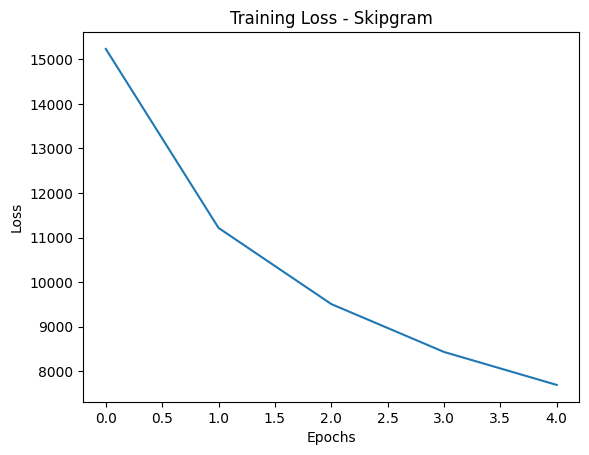

----------------------------------------------------------------------------
Model: SkipgramNegSampling | Epoch:   1/5  Loss: 1152260.2877  Time:   1.95s
Model: SkipgramNegSampling | Epoch:   2/5  Loss:  795451.5784  Time:   2.57s
Model: SkipgramNegSampling | Epoch:   3/5  Loss:  624006.6881  Time:   2.11s
Model: SkipgramNegSampling | Epoch:   4/5  Loss:  488677.5371  Time:   2.37s
Model: SkipgramNegSampling | Epoch:   5/5  Loss:  384440.1143  Time:   2.47s


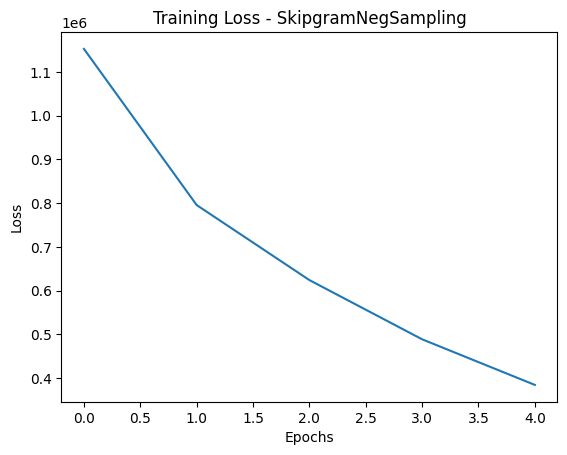

----------------------------------------------------------------------------
Model: GloVe               | Epoch:   1/5  Loss:    1697.2151  Time:   0.72s
Model: GloVe               | Epoch:   2/5  Loss:    1467.3321  Time:   0.61s
Model: GloVe               | Epoch:   3/5  Loss:    1266.9759  Time:   0.64s
Model: GloVe               | Epoch:   4/5  Loss:    1095.8558  Time:   0.60s
Model: GloVe               | Epoch:   5/5  Loss:     949.0527  Time:   0.64s


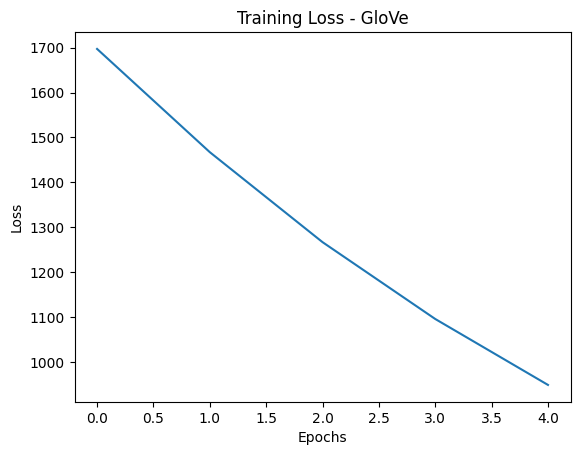

----------------------------------------------------------------------------
All models have been saved.


In [ ]:
import random
import time
import math
from collections import Counter
import matplotlib.pyplot as plt


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
from nltk.corpus import reuters

# Device Configuration
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {device}")

# Download necessary NLTK datasets
nltk.download("reuters")
nltk.download("punkt")
print("----------------------------------------------------------------------------")


# Build Reuters Corpus
def build_corpus(sample_size):
    corpus = []
    # Iterate through the first 'sample_size' files in the Reuters corpus
    for file_id in reuters.fileids()[:sample_size]:
        # Extract words from the file, convert to lowercase, and filter out non-alphabetic tokens
        words = [word.lower() for word in reuters.words(file_id) if word.isalpha()]
        # Append the processed words to the corpus
        corpus.append(words)
    return corpus


# Vocabulary Building
def build_vocab(corpus, min_freq=5):
    # Flatten the corpus to get a list of all words
    words = [word for sentence in corpus for word in sentence]

    # Count the frequency of each word in the corpus
    word_counts = Counter(words)

    # Create a vocabulary list with words that have a frequency greater than or equal to 'min_freq'
    vocab = [word for word, count in word_counts.items() if count >= min_freq]

    # Add a special token for unknown words
    vocab.append("<UNKNOWN>")

    # Create a mapping from words to their indices
    word2index = {word: idx for idx, word in enumerate(vocab)}

    # Ensure the unknown token is mapped to index 0
    word2index["<UNKNOWN>"] = 0

    return vocab, word2index, word_counts


# Generate Skip-grams
def build_skipgrams(corpus, word2index, window_size):
    skip_grams = []
    # Iterate through each sentence in the corpus
    for sentence in corpus:
        # Iterate through each word in the sentence
        for idx, word in enumerate(sentence):
            # Get the index of the center word, default to <UNKNOWN> if not found
            center = word2index.get(word, word2index["<UNKNOWN>"])
            # Define the context window around the center word
            context_window = sentence[max(0, idx - window_size) : idx] + sentence[idx + 1 : idx + window_size + 1]
            # Iterate through each context word in the context window
            for context_word in context_window:
                # Get the index of the context word, default to <UNKNOWN> if not found
                context = word2index.get(context_word, word2index["<UNKNOWN>"])
                # Append the (center, context) pair to the skip_grams list
                skip_grams.append((center, context))
    return skip_grams


def weighting_function(x_ij, x_max=100, alpha=0.75):
    return (x_ij / x_max) ** alpha if x_ij < x_max else 1


# Skipgram Model
class Skipgram(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(Skipgram, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size)
        self.embedding_u = nn.Embedding(vocab_size, embed_size)

    def forward(self, center_words, context_words):
        # Get the embeddings for the center and context words
        center_embed = self.embedding_v(center_words)
        context_embed = self.embedding_u(context_words)

        # Compute the scores by taking the dot product of center and context embeddings
        scores = torch.matmul(center_embed, context_embed.T)

        # Apply log softmax to the scores to get the log probabilities
        log_probs = torch.log_softmax(scores, dim=1)
        return log_probs


# Skipgram Model with Negative Sampling
class SkipgramNegSampling(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size)
        self.embedding_u = nn.Embedding(vocab_size, embed_size)
        self.logsigmoid = nn.LogSigmoid()

    def forward(self, center_words, pos_context, neg_context):
        # Get the embeddings for the center, positive context, and negative context words
        center_embed = self.embedding_v(center_words)
        pos_embed = self.embedding_u(pos_context)
        neg_embed = self.embedding_u(neg_context)

        # Compute the positive score by taking the dot product of center and positive context embeddings
        pos_score = self.logsigmoid(torch.bmm(pos_embed.unsqueeze(1), center_embed.unsqueeze(2))).squeeze()

        # Compute the negative score by taking the dot product of center and negative context embeddings
        neg_score = self.logsigmoid(-torch.bmm(neg_embed, center_embed.unsqueeze(2))).squeeze()

        # Calculate the loss as the negative sum of positive and negative scores
        loss = -(pos_score.sum() + neg_score.sum())
        return loss


# GloVe Model
class GloVe(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(GloVe, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size)
        self.embedding_u = nn.Embedding(vocab_size, embed_size)
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)

    def forward(self, center_words, target_words, co_occurrences, weightings):
        # Get the embeddings for the center and target words
        center_embed = self.embedding_v(center_words)
        target_embed = self.embedding_u(target_words)

        # Get the biases for the center and target words
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)

        # Compute the inner product of the center and target embeddings
        inner_product = (center_embed * target_embed).sum(dim=1)

        # Calculate the loss using the weighting function and co-occurrences
        loss = weightings * torch.pow(inner_product + center_bias + target_bias - co_occurrences, 2)
        return loss.mean()


# Plotting Loss Function
def plot_losses(losses, model_name):
    plt.plot(losses)
    plt.title(f"Training Loss - {model_name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()


# Training Function for Skipgram Models
def train_skipgram(model, skip_grams, epochs, batch_size, learning_rate, word2index, num_neg_samples=5):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []

    for epoch in range(epochs):
        start_time = time.time()
        total_loss = 0

        # Shuffle the skip-grams for each epoch
        random.shuffle(skip_grams)

        for i in range(0, len(skip_grams), batch_size):
            # Extract the current batch from the skip-grams
            batch = skip_grams[i : i + batch_size]

            # Unzip the batch into separate lists for center and context words
            center_words, context_words = zip(*batch)

            # Convert the lists to tensors and move them to CPU/GPU
            center_words = torch.LongTensor(center_words).to(device)
            context_words = torch.LongTensor(context_words).to(device)

            # If the batch is smaller than the batch size, pad with zeros
            if len(batch) < batch_size:
                padding_size = batch_size - len(batch)
                center_words = torch.cat([center_words, torch.zeros(padding_size, dtype=torch.long).to(device)])
                context_words = torch.cat([context_words, torch.zeros(padding_size, dtype=torch.long).to(device)])

            # Zero the gradients
            optimizer.zero_grad()

            # Compute the loss based on the model type
            if isinstance(model, Skipgram):
                log_probs = model(center_words, context_words)
                loss = -torch.mean(log_probs[range(batch_size), context_words])
            else:
                neg_samples = torch.LongTensor([np.random.choice(len(word2index), num_neg_samples) for _ in range(batch_size)]).to(device)
                loss = model(center_words, context_words, neg_samples)

            # Backpropagate the loss and update the model parameters
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(
            f"Model: {model.__class__.__name__:20s}| Epoch: {epoch + 1:-3d}/{epochs}  Loss: {total_loss:12.4f}  Time: {time.time() - start_time:6.2f}s"
        )
        loss_history.append(total_loss)
    plot_losses(loss_history, model.__class__.__name__)


def train_glove_model(model, training_data, epochs, batch_size, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_history = []
    model.train()

    for epoch in range(epochs):
        start_time = time.time()
        total_loss = 0

        # Shuffle the training data for each epoch
        random.shuffle(training_data)

        for i in range(0, len(training_data), batch_size):
            # Extract the current batch from the training data
            batch = training_data[i : i + batch_size]

            # Unzip the batch into separate lists for centers, contexts, co-occurrences, and weights
            centers, contexts, coocs, weights = zip(*batch)

            # Convert the lists to tensors and move them to CPU/GPU
            centers = torch.LongTensor(centers).to(device)
            contexts = torch.LongTensor(contexts).to(device)
            coocs = torch.FloatTensor(coocs).to(device)
            weights = torch.FloatTensor(weights).to(device)

            optimizer.zero_grad()

            loss = model(centers, contexts, coocs, weights)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(
            f"Model: {model.__class__.__name__:20s}| Epoch: {epoch + 1:-3d}/{epochs}  Loss: {total_loss:12.4f}  Time: {time.time() - start_time:6.2f}s"
        )
        loss_history.append(total_loss)
    plot_losses(loss_history, model.__class__.__name__)


# Hyperparameters
SAMPLE_SIZE = 100  # Number of documents to sample from the Reuters corpus
WINDOW_SIZE = 2  # Context window size for skip-grams
EMBEDDING_DIMENSION = 100  # Dimension of the embedding vectors
TOTAL_EPOCHS = 5  # Number of epochs to train the models
BATCH_SIZE = 64  # Batch size for training
LEARNING_RATE = 0.001  # Learning rate for the optimizer

# Build the corpus from the Reuters dataset
corpus = build_corpus(SAMPLE_SIZE)

# Build the vocabulary from the corpus with a minimum frequency threshold
vocab, word2index, word_counts = build_vocab(corpus)

# Generate skip-grams from the corpus using the built vocabulary
skip_grams = build_skipgrams(corpus, word2index, WINDOW_SIZE)

# Train Models
print("----------------------------------------------------------------------------")
model_skipgram = Skipgram(len(vocab), EMBEDDING_DIMENSION).to(device)
train_skipgram(model_skipgram, skip_grams, TOTAL_EPOCHS, BATCH_SIZE, LEARNING_RATE, word2index)
print("----------------------------------------------------------------------------")
model_skipgram_neg = SkipgramNegSampling(len(vocab), EMBEDDING_DIMENSION).to(device)
train_skipgram(model_skipgram_neg, skip_grams, TOTAL_EPOCHS, BATCH_SIZE, LEARNING_RATE, word2index)
print("----------------------------------------------------------------------------")
model_glove = GloVe(len(vocab), EMBEDDING_DIMENSION).to(device)
co_occurrence_matrix = Counter(skip_grams)  # Prepare co-occurrence matrix
training_data_glove = [(center, context, math.log(count + 1), weighting_function(count)) for (center, context), count in co_occurrence_matrix.items()]
train_glove_model(model_glove, training_data_glove, TOTAL_EPOCHS, BATCH_SIZE, LEARNING_RATE)
print("----------------------------------------------------------------------------")

# Save Models
torch.save({"model_state_dict": model_skipgram.state_dict(), "word2index": word2index, "vocab": vocab}, "skipgram_model.pth")
torch.save({"model_state_dict": model_skipgram_neg.state_dict(), "word2index": word2index, "vocab": vocab}, "skipgram_neg_model.pth")
torch.save({"model_state_dict": model_glove.state_dict(), "word2index": word2index, "vocab": vocab}, "glove_model.pth")
print("All models have been saved.")

In [62]:
def load_model(filepath, model_class, vocab_size, embed_size):
    checkpoint = torch.load(filepath, weights_only=False)
    model = model_class(vocab_size, embed_size)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model, checkpoint["word2index"], checkpoint["vocab"]


model_skipgram, word2index_skipgram, vocab_skipgram = load_model("skipgram_model.pth", Skipgram, len(vocab), EMBEDDING_DIMENSION)
model_skipgram_neg, word2index_neg, vocab_neg = load_model("skipgram_neg_model.pth", SkipgramNegSampling, len(vocab), EMBEDDING_DIMENSION)
model_glove, word2index_glove, vocab_glove = load_model("glove_model.pth", GloVe, len(vocab), EMBEDDING_DIMENSION)

from gensim.models import KeyedVectors

model_glove_gensim = KeyedVectors.load_word2vec_format("glove.6B.100d.txt", binary=False, no_header=True)

In [63]:
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error


# Evaluate Analogies
# TODO: Find Semantic Accuracy score using capital-common-countries section of word-test.v1.txt
# TODO: Find Syntactic Accuracy score using gram7-past-tense section of word-test.v1.txt
def evaluate_analogies(model, word2index, analogy_data, is_gensim=False):
    semantic_correct, semantic_total = 0, 0
    syntactic_correct, syntactic_total = 0, 0
    section = None

    for line in analogy_data:
        if line.startswith(":"):
            # Update the section based on the current line
            section = line.strip().lower()
        else:
            # Split the line into words and convert to lowercase
            words = line.strip().lower().split()
            # Check if all words are in the vocabulary
            if all(word in word2index for word in words):
                if is_gensim:
                    # Use Gensim model to find the most similar word
                    predicted = model.most_similar(positive=[words[1], words[2]], negative=[words[0]], topn=1)[0][0]
                else:
                    # Get the indices of the words
                    a, b, c, expected = [word2index[word] for word in words]
                    # Calculate the vector for the predicted word
                    vec = (
                        model.embedding_v(torch.tensor([b])).detach()
                        - model.embedding_v(torch.tensor([a])).detach()
                        + model.embedding_v(torch.tensor([c])).detach()
                    )
                    # Compute similarities and find the word with the highest similarity
                    similarities = torch.matmul(model.embedding_v.weight, vec.squeeze())
                    predicted = torch.argmax(similarities).item()
                # Check if the predicted word matches the expected word
                if predicted == words[3]:
                    if "capital-common-countries" in section:
                        semantic_correct += 1
                    elif "gram7-past-tense" in section:
                        syntactic_correct += 1
                # Update the total counts for semantic and syntactic sections
                if "capital-common-countries" in section:
                    semantic_total += 1
                elif "gram7-past-tense" in section:
                    syntactic_total += 1

    # Calculate accuracy for semantic and syntactic sections
    semantic_accuracy = semantic_correct / semantic_total if semantic_total else 0
    syntactic_accuracy = syntactic_correct / syntactic_total if syntactic_total else 0
    print(f"Semantic Accuracy (Capital-Common-Countries): {semantic_accuracy:.4f}")
    print(f"Syntactic Accuracy (Gram7-Past-Tense): {syntactic_accuracy:.4f}")


# Evaluate Similarity
# TODO: Find the correlation between your models’ dot product and the provided similarity metrics (spearmanr). Output is MSE score.
# TODO: Assess if your embeddings correlate with human judgment of word similarity against the wordsim_similarity_goldstandard.txt file.
def evaluate_similarity(model, word2index, similarity_data, is_gensim=False):
    predictions = []
    ground_truth = []
    for line in similarity_data:
        # Split the line into words and the similarity score
        word1, word2, score = line.strip().split()
        # Check if both words are in the vocabulary
        if word1 in word2index and word2 in word2index:
            if is_gensim:
                # Use Gensim model to calculate similarity
                similarity = model.similarity(word1, word2)
            else:
                # Get the embeddings for the words
                vec1 = model.embedding_v(torch.tensor([word2index[word1]])).detach()
                vec2 = model.embedding_v(torch.tensor([word2index[word2]])).detach()
                # Calculate the dot product similarity
                similarity = torch.dot(vec1.squeeze(), vec2.squeeze()).item()
            # Append the similarity and ground truth score to the lists
            predictions.append(similarity)
            ground_truth.append(float(score))
    # Calculate Spearman correlation between predictions and ground truth
    spearman_corr, _ = spearmanr(predictions, ground_truth)
    # Calculate Mean Squared Error (MSE) between predictions and ground truth
    mse_score = mean_squared_error(ground_truth, predictions)
    print(f"Spearman Correlation: {spearman_corr:.4f}")
    print(f"Mean Squared Error (MSE): {mse_score:.4f}")

In [64]:
# Load analogy and similarity datasets
with open("word-test.v1.txt", "r") as file:
    analogy_data = file.readlines()

with open("wordsim_similarity_goldstandard.txt", "r") as file:
    similarity_data = file.readlines()

# Run Evaluations
print("--- Skipgram Model ---")
evaluate_analogies(model_skipgram, word2index_skipgram, analogy_data)
evaluate_similarity(model_skipgram, word2index_skipgram, similarity_data)

print("--- Skipgram Negative Sampling Model ---")
evaluate_analogies(model_skipgram_neg, word2index_neg, analogy_data)
evaluate_similarity(model_skipgram_neg, word2index_neg, similarity_data)

print("--- GloVe PyTorch Model ---")
evaluate_analogies(model_glove, word2index_glove, analogy_data)
evaluate_similarity(model_glove, word2index_glove, similarity_data)

print("--- GloVe Gensim Model ---")
evaluate_analogies(model_glove_gensim, model_glove_gensim.key_to_index, analogy_data, is_gensim=True)
evaluate_similarity(model_glove_gensim, model_glove_gensim.key_to_index, similarity_data, is_gensim=True)

--- Skipgram Model ---
Semantic Accuracy (Capital-Common-Countries): 0.0000
Syntactic Accuracy (Gram7-Past-Tense): 0.0000
Spearman Correlation: -0.4524
Mean Squared Error (MSE): 105.4528
--- Skipgram Negative Sampling Model ---
Semantic Accuracy (Capital-Common-Countries): 0.0000
Syntactic Accuracy (Gram7-Past-Tense): 0.0000
Spearman Correlation: -0.1667
Mean Squared Error (MSE): 95.4902
--- GloVe PyTorch Model ---
Semantic Accuracy (Capital-Common-Countries): 0.0000
Syntactic Accuracy (Gram7-Past-Tense): 0.0000
Spearman Correlation: -0.0714
Mean Squared Error (MSE): 59.1276
--- GloVe Gensim Model ---
Semantic Accuracy (Capital-Common-Countries): 0.9387
Syntactic Accuracy (Gram7-Past-Tense): 0.5545
Spearman Correlation: 0.6019
Mean Squared Error (MSE): 27.8562


In [84]:
import pandas as pd


# Find Top 10 Most Similar Words Based on Dot Product
def find_top_similar_words(model, word2index, index2word, input_word, top_n=10, is_gensim=False):
    if is_gensim:
        if input_word not in model:
            print(f"'{input_word}' not in vocabulary.")
            return
        similar_words = model.most_similar(input_word, topn=top_n)
        print(f"Top {top_n} words similar to '{input_word}':")
        for word, similarity in similar_words:
            print(f"Model: {'Gensim':20s}  Word: {word:15s}  Similarity: {similarity:.4f}")
    else:
        if input_word not in word2index:
            print(f"'{input_word}' not in vocabulary.")
            return
        input_vec = model.embedding_v(torch.tensor([word2index[input_word]])).detach()
        similarities = torch.matmul(model.embedding_v.weight, input_vec.squeeze())
        probabilities = torch.softmax(similarities, dim=0)
        top_indices = torch.topk(probabilities, top_n + 1).indices.tolist()[1:]
        print(f"Top {top_n} words similar to '{input_word}':")
        for idx in top_indices:
            print(f"Model: {model.__class__.__name__:20s}  Word: {index2word[idx]:15s}  Similarity: {similarities[idx]:.4f}")
    print("-----------------------------------------------------------------------")


# Example usage for finding top similar words
find_top_similar_words(model_skipgram, word2index_glove, vocab_glove, "dollar")
find_top_similar_words(model_skipgram_neg, word2index_glove, vocab_glove, "dollar")
find_top_similar_words(model_glove, word2index_glove, vocab_glove, "dollar")
find_top_similar_words(model_glove_gensim, model_glove_gensim.key_to_index, None, "dollar", is_gensim=True)

Top 10 words similar to 'dollar':
Model: Skipgram              Word: put              Similarity: 20.9706
Model: Skipgram              Word: owned            Similarity: 19.8244
Model: Skipgram              Word: must             Similarity: 19.5910
Model: Skipgram              Word: taking           Similarity: 19.3249
Model: Skipgram              Word: forecast         Similarity: 19.0773
Model: Skipgram              Word: shareholders     Similarity: 18.1679
Model: Skipgram              Word: deficit          Similarity: 18.0835
Model: Skipgram              Word: drop             Similarity: 18.0519
Model: Skipgram              Word: australia        Similarity: 17.8454
Model: Skipgram              Word: against          Similarity: 17.7679
-----------------------------------------------------------------------
Top 10 words similar to 'dollar':
Model: SkipgramNegSampling   Word: canada           Similarity: 29.0228
Model: SkipgramNegSampling   Word: electric         Similarity: 27.7